In [44]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
from torch.utils.data import Subset, DataLoader, TensorDataset, random_split, ConcatDataset
from sklearn.model_selection import train_test_split

import torchvision
import torchvision.transforms as T

import sys
import copy


import matplotlib.pyplot as plt


In [ ]:
transform = T.Compose([
    T.ToTensor(),
    T.Normalize(0.17222730815410614, 0.3309466242790222)
])

train_set = torchvision.datasets.EMNIST(
    root='./data/emnist', split='letters', transform=transform, train=True, download=True)

train_set.classes = train_set.classes[1:]
train_set.targets = train_set.targets - 1

val_dataset = torchvision.datasets.EMNIST(
    root='./data/emnist', split='letters', transform=transform, train=False, download=True)

val_dataset.classes = val_dataset.classes[1:]
val_dataset.targets = val_dataset.targets - 1

print("train_classes", len(train_set.classes))
print("val_classes", (len(val_dataset.classes)))
print("train_classes", len(train_set.classes))
print("train_targets", torch.unique(train_set.targets))
print("val_targets", torch.unique(val_dataset.targets))

val_set, test_set = random_split(val_dataset, [.5, .5])


In [ ]:
print('Data shapes:')
print(f"Image Shape: {train_set.data[0].shape}")
print(f"Classes: {len(train_set.classes)}")

print(f"Train Set: {len(train_set)}")
print(f"Val Set: {len(val_set)}")
print(f"Test Set: {len(val_set)}")

# Categories
print(f'\nData categories:\n{train_set.classes}')


In [48]:
batch_size = 64
train_loader = DataLoader(
    train_set, batch_size=batch_size, shuffle=True, drop_last=True)
val_loader = DataLoader(val_set, batch_size=len(val_set))
test_loader = DataLoader(test_set, batch_size=len(test_set))


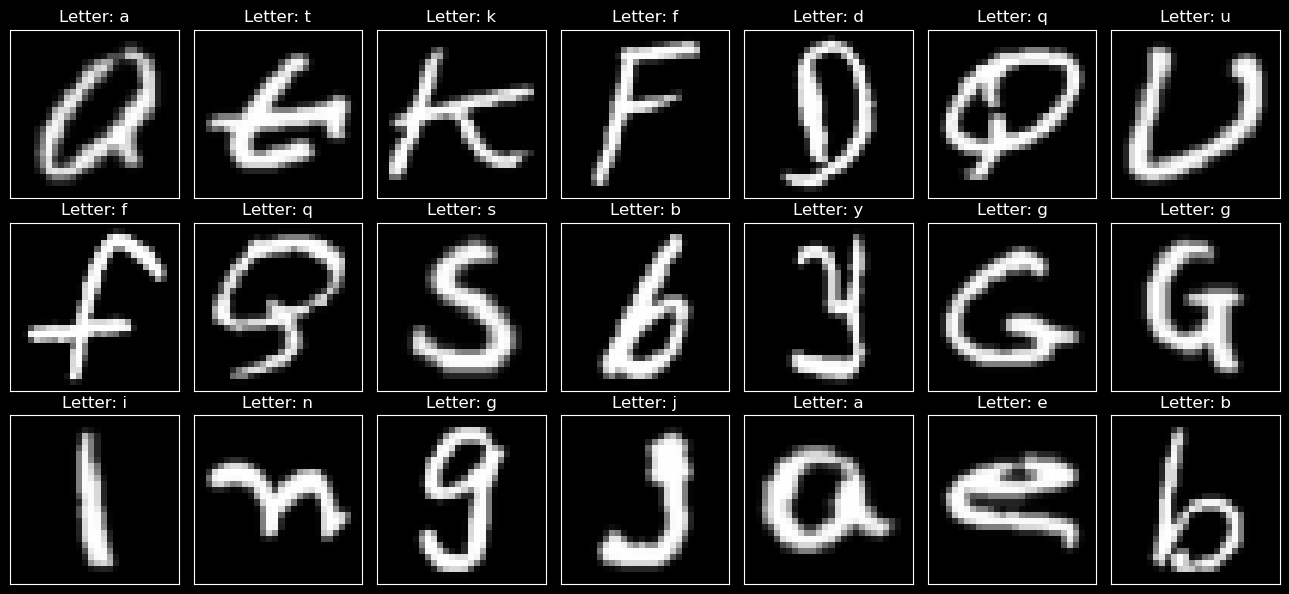

In [49]:
# Visualize data
fig, axs = plt.subplots(3, 7, figsize=(13, 6))

for (i, ax) in enumerate(axs.flatten()):

    # extract that image
    pic_i = np.random.randint(val_dataset.data.shape[0])
    pic = val_dataset.data[pic_i, :, :].numpy().transpose(1, 0)

    # and its label
    label = val_dataset.classes[val_dataset.targets[pic_i]]

    # and show!
    ax.imshow(pic, cmap='gray')
    ax.set_title(f"Letter: {label}")
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.show()


In [50]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


In [152]:
def create_model():
    net = nn.Sequential(
        nn.Conv2d(1, 64, kernel_size=4, padding=1),
        nn.BatchNorm2d(64),
        nn.GELU(),
        nn.Conv2d(64, 64, kernel_size=4, padding=1),
        nn.BatchNorm2d(64),
        nn.GELU(),
        nn.MaxPool2d(2),
        nn.Dropout(0.25),

        nn.Conv2d(64, 128, kernel_size=4, padding=1),
        nn.BatchNorm2d(128),
        nn.GELU(),
        nn.Conv2d(128, 128, kernel_size=4, padding=1),
        nn.BatchNorm2d(128),
        nn.GELU(),
        nn.MaxPool2d(2),
        nn.Dropout(0.25),

        nn.Conv2d(128, 256, kernel_size=4, padding=1),
        nn.BatchNorm2d(256),
        nn.GELU(),
        nn.Conv2d(256, 256, kernel_size=4, padding=1),
        nn.BatchNorm2d(256),
        nn.GELU(),
        nn.MaxPool2d(2),
        nn.Dropout(0.25),

        nn.Flatten(),
        nn.Linear(256, 26),
    )
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(
        net.parameters(), lr=.001, weight_decay=1e-5, momentum=.9)

    return net, criterion, optimizer


test_net, criterion, optimizer = create_model()


In [ ]:
test_net, criterion, optimizer = create_model()
# Test that the model works
X, y = next(iter(train_loader))
yHat = test_net(X)

summary(test_net.cuda(), (1, 28, 28))


In [154]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# device = "cpu"


def train_model(epochs=25):

    model, criterion, optimizer = create_model()
    model.to(device)

    step_size = 64*len(train_loader.dataset)
    def lambda1(epoch): return 0.65 ** epoch

    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=.5)
    # scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[1,20], gamma=.1)

    # call this meta
    meta = {"epoch": 0, "loss": np.inf, "val_acc": 0, "state": None}

    train_loss, val_loss = torch.zeros(epochs), torch.zeros(epochs)
    train_acc, val_acc = torch.zeros(epochs), torch.zeros(epochs)

    for epoch in range(epochs):
        model.train()
        batch_loss, batch_acc = [], []
        for X, y in train_loader:
            X, y = X.to(device), y.to(device)

            y_hat = model(X)
            loss = criterion(y_hat, y)

            # Back propagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            scheduler.step()

            batch_loss.append(loss.item())
            batch_acc.append(torch.mean(
                (torch.argmax(y_hat, axis=1) == y).float()).item())

        train_loss[epoch] = np.mean(batch_loss)
        train_acc[epoch] = np.mean(batch_acc)

        model.eval()
        X, y = next(iter(val_loader))
        X, y = X.to(device), y.to(device)
        with torch.no_grad():
            y_hat = model(X)
            loss = criterion(y_hat, y)

        val_loss[epoch] = loss.item()
        val_acc[epoch] = torch.mean(
            (torch.argmax(y_hat, axis=1) == y).float()).item()

        if(meta["loss"] > val_loss[epoch]):
            meta = {"loss": val_loss[epoch], "epoch": epoch, "val_acc": val_acc[epoch],
                    "state": copy.deepcopy(model.state_dict())}
        # Print logs
        print(f"Epoch {(epoch+1)}/{epochs}",
              f"- loss: {train_loss[epoch]:.4f}",
              f"- acc: {train_acc[epoch]:.4f}",
              f"- val_loss: {val_loss[epoch]:.4f}",
              f"- val_acc: {val_acc[epoch]:.4f}"
            #   f" - Best: acc: {meta['val_acc']:.4f}"
              )

    # model.load_state_dict(meta["state"])
    return model, train_loss, val_loss, train_acc, val_acc, meta


In [155]:
import gc
torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats()

seed = 42
torch.manual_seed(seed)
gc.collect()
torch.cuda.memory_allocated()



In [ ]:
net, train_loss, val_loss, train_acc, val_acc, meta = train_model(100)
# switch to test mode
# net.cpu()
# net.eval()



In [ ]:
net.eval()
X, y = next(iter(test_loader))
X, y = X.to(device), y.to(device)
with torch.no_grad():
    y_hat = net(X)
    loss_fun = criterion(y_hat, y)

test_loss = loss_fun.item()
test_acc = torch.mean((torch.argmax(y_hat, axis=1) == y).float()).item()

print(test_acc)


0.8892307877540588


In [ ]:
X, y = next(iter(test_loader))
X, y = X.to(device), y.to(device)
y_hat = net(X)

error_indices = np.where(torch.argmax(y_hat.cpu(), axis=1) != y.cpu())[0]
errors_n = len(error_indices)

print(f"Mismatches: {errors_n}")

Mismatches: 1198


In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(16, 5))

ax[0].plot(train_loss, 's-', label="Train")
ax[0].plot(val_loss, 'o-', label="Val")
ax[0].plot(len(val_loss)-1, test_loss, 'r*', markersize=15, label='Test')

ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_title('Model loss')
ax[0].legend()

ax[1].plot(train_acc, 's-', label='Train')
ax[1].plot(val_acc, 'o-', label='Val')
ax[1].plot(len(val_acc)-1, test_acc, 'r*', markersize=15, label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_title(
    f'Final model val/test accuracy: {val_acc[-1]*100:.2f}/ {test_acc*100:.2f}%')
ax[1].legend()

plt.show()
